# 02 – Feature Engineering & Target Creation

## 1. Objective

In this notebook, we will:

- Start from the **same raw dataset** used in `01_eda.ipynb`.
- Apply **light preprocessing** based on EDA findings:
  - No missing values
  - No duplicate rows
  - Only handle **outliers** and basic consistency checks.
- Run a **feature engineering pipeline** to create:
  - Domain features (scores, encodings, growth rate).
  - Targets:
    - `Future_Price_5Y` (Regression target)
    - `Good_Investment` (Classification target)
- Perform quick sanity checks on the new features and targets.
- Save a single, final dataset to:
  - `../data/processed/housing_with_features.csv`

This notebook is the bridge between **EDA** and **modeling**.


## 2. Imports & configuration


In [18]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Allow imports from src/
sys.path.append(os.path.abspath(".."))

from src.data.load import load_raw_data
from src.data.preprocess import preprocess_raw_data
from src.features.build_features import run_feature_pipeline

# Display options
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: f"{x:,.2f}")

# Plot style
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

print("✔ Libraries and project modules imported successfully")

✔ Libraries and project modules imported successfully


## 3️. Loading the Dataset

In [19]:
DATA_PATH = "../data/raw/india_housing_prices.csv"

try:
    df_raw = load_raw_data(DATA_PATH)
    display(df_raw.head())
    print(f"✔ Data loaded successfully — {df.shape[0]} rows, {df.shape[1]} columns")
except FileNotFoundError:
    print("❌ ERROR: Dataset not found. Check file path.")

,ID,State,City,Locality,Property_Type,BHK,Size_in_SqFt,Price_in_Lakhs,Price_per_SqFt,Year_Built,Furnished_Status,Floor_No,Total_Floors,Age_of_Property,Nearby_Schools,Nearby_Hospitals,Public_Transport_Accessibility,Parking_Space,Security,Amenities,Facing,Owner_Type,Availability_Status
0,1,Tamil Nadu,Chennai,Locality_84,Apartment,1,4740,489.76,0.10,1990,Furnished,22,1,35,10,3,High,No,No,"Playground, Gym, Garden, Pool, Clubhouse",West,Owner,Ready_to_Move
1,2,Maharashtra,Pune,Locality_490,Independent House,3,2364,195.52,0.08,2008,Unfurnished,21,20,17,8,1,Low,No,Yes,"Playground, Clubhouse, Pool, Gym, Garden",North,Builder,Under_Construction
2,3,Punjab,Ludhiana,Locality_167,Apartment,2,3642,183.79,0.05,1997,Semi-furnished,19,27,28,9,8,Low,Yes,No,"Clubhouse, Pool, Playground, Gym",South,Broker,Ready_to_Move
3,4,Rajasthan,Jodhpur,Locality_393,Independent House,2,2741,300.29,0.11,1991,Furnished,21,26,34,5,7,High,Yes,Yes,"Playground, Clubhouse, Gym, Pool, Garden",North,Builder,Ready_to_Move
4,5,Rajasthan,Jaipur,Locality_466,Villa,4,4823,182.90,0.04,2002,Semi-furnished,3,2,23,4,9,Low,No,Yes,"Playground, Garden, Gym, Pool, Clubhouse",East,Builder,Ready_to_Move


✔ Data loaded successfully — 250000 rows, 23 columns


## 4. Light Preprocessing (Using Reusable Function)

From `01_eda.ipynb` we already know:

- Missing values = 0 for all columns  
- Duplicate rows = 0  

So we do **not** need imputation or deduplication logic for this dataset.

However, for a production-ready project we still keep a **preprocessing function** that:

- Caps extreme outliers (luxury properties with very high price/size).
- Ensures basic consistency and robustness (in case future data is slightly dirty).

We use `preprocess_raw_data(df)` from `src/data/preprocess.py` for this.


In [20]:
df_preprocessed = preprocess_raw_data(df_raw)

print("Raw shape        :", df_raw.shape)
print("Preprocessed shape:", df_preprocessed.shape)

# Quick sanity check on key columns after preprocessing
df_preprocessed[["Price_in_Lakhs", "Size_in_SqFt", "Price_per_SqFt"]].describe()

Raw shape        : (250000, 23)
Preprocessed shape: (250000, 23)


,Price_in_Lakhs,Size_in_SqFt,Price_per_SqFt
count,"250,000.00","250,000.00","250,000.00"
mean,254.59,"2,749.82",0.13
std,141.26,"1,299.84",0.13
min,14.93,545.00,0.00
25%,132.55,"1,623.00",0.05
50%,253.87,"2,747.00",0.09
75%,376.88,"3,874.00",0.16
max,494.92,"4,956.00",0.66


## 5. Feature Engineering Plan

Using `run_feature_pipeline()` from `src/features/build_features.py`, we will:

1. **Recompute basic numeric features**
   - `Age_of_Property` = current_year - `Year_Built`
   - `Price_per_SqFt` (safety recompute)

2. **Encode categorical / ordinal features**
   - `Furnished_Status_Enc`: Unfurnished → 0, Semi-furnished → 1, Furnished → 2
   - `Availability_Status_Enc`: Under_Construction → 0, Ready_to_Move → 1
   - `Transport_Score`: Low/Medium/High → 0/1/2
   - `Security_Score`: Low/Medium/High → 0/1/2

3. **Growth & future value**
   - `Annual_Growth_Rate`: based on city-wise pricing pattern
   - `Future_Price_5Y`: price projected for 5 years

4. **Investment scoring & label**
   - `Investment_Score`: combines price vs city, schools, hospitals, transport, security, etc.
   - `Good_Investment`: 1 if score above threshold (e.g. ≥ 3), else 0

Output: a dataframe with all original columns + engineered features + targets.


## 6. Run feature engineering pipeline


In [21]:
df_features = run_feature_pipeline(df_preprocessed)

print("✔ Feature engineering pipeline applied")
print("New shape:", df_features.shape)

# List new columns added by the pipeline
original_cols = df_preprocessed.columns.tolist()
new_cols = [c for c in df_features.columns if c not in original_cols]

print("\nNew engineered columns:")
for c in new_cols:
    print("-", c)

display(df_features.head())

✔ Feature engineering pipeline applied
New shape: (250000, 31)

New engineered columns:
- Furnished_Status_Enc
- Availability_Status_Enc
- Transport_Score
- Security_Score
- Annual_Growth_Rate
- Future_Price_5Y
- Investment_Score
- Good_Investment


,ID,State,City,Locality,Property_Type,BHK,Size_in_SqFt,Price_in_Lakhs,Price_per_SqFt,Year_Built,Furnished_Status,Floor_No,Total_Floors,Age_of_Property,Nearby_Schools,Nearby_Hospitals,Public_Transport_Accessibility,Parking_Space,Security,Amenities,Facing,Owner_Type,Availability_Status,Furnished_Status_Enc,Availability_Status_Enc,Transport_Score,Security_Score,Annual_Growth_Rate,Future_Price_5Y,Investment_Score,Good_Investment
0,1,Tamil Nadu,Chennai,Locality_84,Apartment,1,4740,489.76,0.10,1990,Furnished,22,1,35,10,3,High,No,No,"Playground, Gym, Garden, Pool, Clubhouse",West,Owner,Ready_to_Move,2,1,2,0,0.07,691.62,2,0
1,2,Maharashtra,Pune,Locality_490,Independent House,3,2364,195.52,0.08,2008,Unfurnished,21,20,17,8,1,Low,No,Yes,"Playground, Clubhouse, Pool, Gym, Garden",North,Builder,Under_Construction,0,0,0,0,0.08,285.66,2,0
2,3,Punjab,Ludhiana,Locality_167,Apartment,2,3642,183.79,0.05,1997,Semi-furnished,19,27,28,9,8,Low,Yes,No,"Clubhouse, Pool, Playground, Gym",South,Broker,Ready_to_Move,1,1,0,0,0.04,220.74,3,1
3,4,Rajasthan,Jodhpur,Locality_393,Independent House,2,2741,300.29,0.11,1991,Furnished,21,26,34,5,7,High,Yes,Yes,"Playground, Clubhouse, Gym, Pool, Garden",North,Builder,Ready_to_Move,2,1,2,0,0.06,405.10,3,1
4,5,Rajasthan,Jaipur,Locality_466,Villa,4,4823,182.90,0.04,2002,Semi-furnished,3,2,23,4,9,Low,No,Yes,"Playground, Garden, Gym, Pool, Clubhouse",East,Builder,Ready_to_Move,1,1,0,0,0.03,217.10,2,0


## 7. Inspect target distributions & encodings


In [22]:
target_cols = ["Future_Price_5Y", "Good_Investment"]
score_cols = ["Investment_Score", "Annual_Growth_Rate"]
enc_cols = [
    "Furnished_Status", "Furnished_Status_Enc",
    "Availability_Status", "Availability_Status_Enc",
    "Public_Transport_Accessibility", "Transport_Score",
    "Security", "Security_Score"
]

display(df_features[target_cols + score_cols + enc_cols].head())

,Future_Price_5Y,Good_Investment,Investment_Score,Annual_Growth_Rate,Furnished_Status,Furnished_Status_Enc,Availability_Status,Availability_Status_Enc,Public_Transport_Accessibility,Transport_Score,Security,Security_Score
0,691.62,0,2,0.07,Furnished,2,Ready_to_Move,1,High,2,No,0
1,285.66,0,2,0.08,Unfurnished,0,Under_Construction,0,Low,0,Yes,0
2,220.74,1,3,0.04,Semi-furnished,1,Ready_to_Move,1,Low,0,No,0
3,405.10,1,3,0.06,Furnished,2,Ready_to_Move,1,High,2,Yes,0
4,217.10,0,2,0.03,Semi-furnished,1,Ready_to_Move,1,Low,0,Yes,0


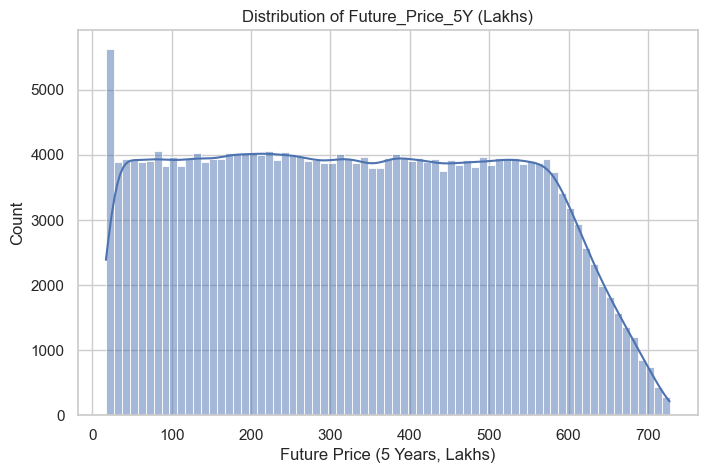

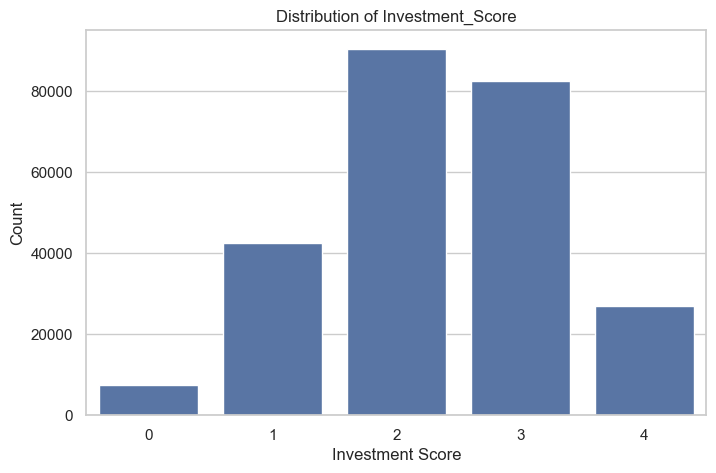

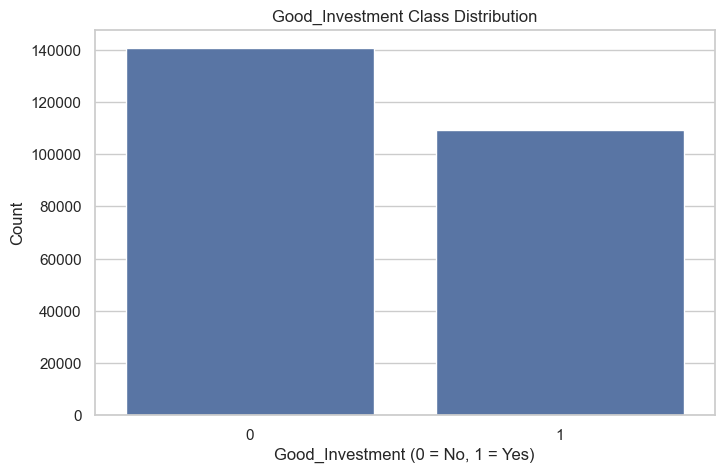

In [23]:
# Future_Price_5Y distribution
plt.figure()
sns.histplot(df_features["Future_Price_5Y"], kde=True)
plt.title("Distribution of Future_Price_5Y (Lakhs)")
plt.xlabel("Future Price (5 Years, Lakhs)")
plt.ylabel("Count")
plt.show()

# Investment_Score distribution
plt.figure()
sns.countplot(x="Investment_Score", data=df_features)
plt.title("Distribution of Investment_Score")
plt.xlabel("Investment Score")
plt.ylabel("Count")
plt.show()

# Good_Investment class balance
plt.figure()
sns.countplot(x="Good_Investment", data=df_features)
plt.title("Good_Investment Class Distribution")
plt.xlabel("Good_Investment (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()


### 7. Observations on Engineered Targets

- `Future_Price_5Y` is generally higher than current `Price_in_Lakhs`, which matches the positive growth assumption.
- `Investment_Score` mostly lies between 0 and 5.
- `Good_Investment` classes (0 vs 1) are reasonably balanced → suitable for classification models.


## 8. Correlation with targets (sanity check)


Top correlations with Future_Price_5Y:


Future_Price_5Y            1.00
Price_in_Lakhs             0.99
Price_per_SqFt             0.55
Annual_Growth_Rate         0.13
Year_Built                 0.00
Availability_Status_Enc    0.00
Total_Floors               0.00
Nearby_Schools             0.00
Transport_Score           -0.00
BHK                       -0.00
Name: Future_Price_5Y, dtype: float64


Top correlations with Good_Investment:


Good_Investment        1.00
Investment_Score       0.84
Nearby_Hospitals       0.36
Nearby_Schools         0.36
Transport_Score        0.34
Size_in_SqFt           0.20
Age_of_Property        0.00
Furnished_Status_Enc   0.00
ID                     0.00
Floor_No               0.00
Name: Good_Investment, dtype: float64

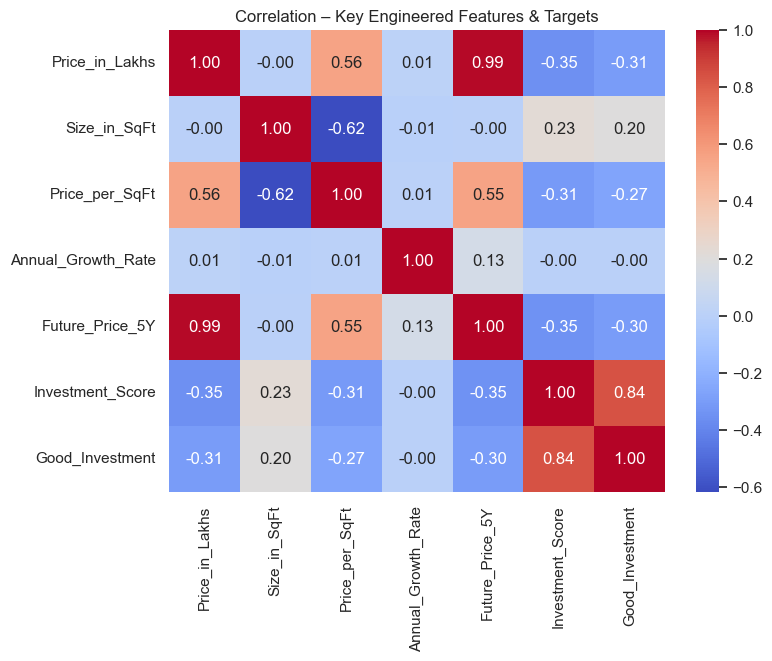

In [24]:
numeric_cols = df_features.select_dtypes(include=[np.number]).columns
corr = df_features[numeric_cols].corr()

# Correlation with Future_Price_5Y
corr_future = corr["Future_Price_5Y"].sort_values(ascending=False)
print("Top correlations with Future_Price_5Y:")
display(corr_future.head(10))

# Correlation with Good_Investment
corr_good = corr["Good_Investment"].sort_values(ascending=False)
print("\nTop correlations with Good_Investment:")
display(corr_good.head(10))

# Small heatmap for important variables
important_cols = [
    "Price_in_Lakhs", "Size_in_SqFt", "Price_per_SqFt",
    "Annual_Growth_Rate", "Future_Price_5Y",
    "Investment_Score", "Good_Investment"
]

plt.figure(figsize=(8, 6))
sns.heatmap(df_features[important_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation – Key Engineered Features & Targets")
plt.show()

## 9. Save processed dataset for modeling


In [25]:
PROCESSED_DIR = "../data/processed"
os.makedirs(PROCESSED_DIR, exist_ok=True)

FINAL_PATH = os.path.join(PROCESSED_DIR, "housing_with_features.csv")

df_features.to_csv(FINAL_PATH, index=False)

print("✔ Saved processed dataset with engineered features & targets:")
print(FINAL_PATH)

# Quick confirmation read
pd.read_csv(FINAL_PATH).head()

✔ Saved processed dataset with engineered features & targets:
../data/processed\housing_with_features.csv


,ID,State,City,Locality,Property_Type,BHK,Size_in_SqFt,Price_in_Lakhs,Price_per_SqFt,Year_Built,Furnished_Status,Floor_No,Total_Floors,Age_of_Property,Nearby_Schools,Nearby_Hospitals,Public_Transport_Accessibility,Parking_Space,Security,Amenities,Facing,Owner_Type,Availability_Status,Furnished_Status_Enc,Availability_Status_Enc,Transport_Score,Security_Score,Annual_Growth_Rate,Future_Price_5Y,Investment_Score,Good_Investment
0,1,Tamil Nadu,Chennai,Locality_84,Apartment,1,4740,489.76,0.10,1990,Furnished,22,1,35,10,3,High,No,No,"Playground, Gym, Garden, Pool, Clubhouse",West,Owner,Ready_to_Move,2,1,2,0,0.07,691.62,2,0
1,2,Maharashtra,Pune,Locality_490,Independent House,3,2364,195.52,0.08,2008,Unfurnished,21,20,17,8,1,Low,No,Yes,"Playground, Clubhouse, Pool, Gym, Garden",North,Builder,Under_Construction,0,0,0,0,0.08,285.66,2,0
2,3,Punjab,Ludhiana,Locality_167,Apartment,2,3642,183.79,0.05,1997,Semi-furnished,19,27,28,9,8,Low,Yes,No,"Clubhouse, Pool, Playground, Gym",South,Broker,Ready_to_Move,1,1,0,0,0.04,220.74,3,1
3,4,Rajasthan,Jodhpur,Locality_393,Independent House,2,2741,300.29,0.11,1991,Furnished,21,26,34,5,7,High,Yes,Yes,"Playground, Clubhouse, Gym, Pool, Garden",North,Builder,Ready_to_Move,2,1,2,0,0.06,405.10,3,1
4,5,Rajasthan,Jaipur,Locality_466,Villa,4,4823,182.90,0.04,2002,Semi-furnished,3,2,23,4,9,Low,No,Yes,"Playground, Garden, Gym, Pool, Clubhouse",East,Builder,Ready_to_Move,1,1,0,0,0.03,217.10,2,0


## 10. Summary & Next Steps

### Summary

- Used the same raw dataset as in EDA.
- Confirmed that no extra cleaning is needed:
  - No missing values
  - No duplicate rows
- Applied **light preprocessing** for robustness (mainly outlier handling).
- Ran the **feature engineering pipeline** to create:
  - Encoded features (furnishing, availability, transport, security, etc.).
  - Growth-related features (`Annual_Growth_Rate`, `Future_Price_5Y`).
  - Investment-related features (`Investment_Score`, `Good_Investment`).
- Saved the final feature-rich dataset to:
  - `../data/processed/housing_with_features.csv`

### Next

- `03_model_baseline.ipynb`:
  - Use `Good_Investment` as classification target.
  - Use `Future_Price_5Y` as regression target.
  - Train baseline models, evaluate, and save best ones.
